In [8]:
# Loader

import pandas as pd
from numpy import integer

daily_aggregated_data = None
daily_total_hits = None
query_country_date = None
real_avg_gmv = None
daily_engine_data = None

daily_aggregated_raw_data = pd.read_csv("daily_aggregated_data.csv")
daily_aggregated_data = (
    daily_aggregated_raw_data
    .groupby(["query", "country", "search_engine"], group_keys=False)
    .apply(lambda x: x[["avg_gmv", "std_gmv", "max_day_gmv", "min_cap", "max_cap"]]
           .iloc[0].to_dict(), include_groups=False)
)

daily_total_hits_raw_data = pd.read_csv("daily_hits.csv")
daily_total_hits = (
    daily_total_hits_raw_data
    .groupby(["query", "country", "date"], group_keys=False)
    .apply(lambda x: x[["total_day_hits"]]
           .iloc[0].to_dict(), include_groups=False)
)

query_country_date_raw_data = pd.read_csv("query_country_date.csv")
query_country_date = (
    query_country_date_raw_data
    .groupby(["query", "country"], group_keys=False)
    .apply(lambda x: x[["min_date", "max_date"]]
           .iloc[0].to_dict(), include_groups=False)
)

real_avg_gmv_raw_data = pd.read_csv("real_avg_gmv.csv")
real_avg_gmv = (
    real_avg_gmv_raw_data
    .groupby(["query", "country"], group_keys=False)
    .apply(lambda x: x[["total_real_avg_gmv"]]
           .iloc[0].to_dict(), include_groups=False)
)

daily_engine_data_raw_data = pd.read_csv("daily_engine_data.csv")
daily_engine_data = (
    daily_engine_data_raw_data
    .groupby(["query", "country", "search_engine", "date"], group_keys=False)
    .apply(lambda x: x[["total_daily_hits", "total_daily_gmv"]]
           .iloc[0].to_dict(), include_groups=False)
)

In [9]:
#Lodaer Reader

from typing import Tuple


def get_gmv_data(query: str, country: str, engine: str) -> Tuple[float, float, float, float, float]:
    if daily_aggregated_data is None:
        raise Exception("Data not loaded")

    if (query, country, engine) not in daily_aggregated_data:
        return NOT_VALID_DATA, NOT_VALID_DATA, NOT_VALID_DATA, NOT_VALID_DATA, NOT_VALID_DATA

    avg_gmv = daily_aggregated_data[query, country, engine]["avg_gmv"]
    std_gmv = daily_aggregated_data[query, country, engine]["std_gmv"]
    max_day_gmv = daily_aggregated_data[query, country, engine]["max_day_gmv"]
    min_cap = daily_aggregated_data[query, country, engine]["min_cap"]
    max_cap = daily_aggregated_data[query, country, engine]["max_cap"]

    return avg_gmv, std_gmv, max_day_gmv, min_cap, max_cap


def get_daily_total_hits(query: str, country: str, date: str) -> int:
    if daily_total_hits is None:
        raise Exception("Data not loaded")

    if (query, country, date) not in daily_total_hits:
        return NOT_VALID_DATA

    if daily_total_hits[query, country, date]["total_day_hits"] is not None:
        return daily_total_hits[query, country, date]["total_day_hits"]

    return NOT_VALID_DATA


def get_all_query_time_range(query: str, country: str) -> Tuple[str, str]:
    if query_country_date is None:
        raise Exception("Data not loaded")

    if (query, country) not in query_country_date:
        return NOT_VALID_DATA, NOT_VALID_DATA

    return (query_country_date[query, country]["min_date"],
            query_country_date[query, country]["max_date"])


def get_real_avg_gmv(query: str, country: str) -> float:
    if real_avg_gmv is None:
        raise Exception("Data not loaded")

    if (query, country) not in real_avg_gmv:
        return NOT_VALID_DATA

    return real_avg_gmv[query, country]["total_real_avg_gmv"]


def get_daily_engine_data(query: str, country: str, engine: str, date: str) -> Tuple[float, int]:
    if daily_engine_data is None:
        raise Exception("Data not loaded")

    if (query, country, engine, date) not in daily_engine_data:
        return NOT_VALID_DATA, NOT_VALID_DATA

    total_daily_gmv = daily_engine_data[query, country, engine, date]["total_daily_gmv"]
    total_daily_hits = daily_engine_data[query, country, engine, date]["total_daily_hits"]
    return total_daily_gmv, total_daily_hits

In [10]:
# Utils

from typing import TypeVar, Generic
from dataclasses import dataclass

T = TypeVar('T')


@dataclass
class Range(Generic[T]):
    left: T
    right: T

    def __str__(self):
        return f"(left:{self.left}, right:{self.right})"

    def __repr__(self):
        return f"(left:{self.left}, right:{self.right})"


import numpy as np
from scipy.special import softmax


def generate_gmv_sample(avg: float, std: float, min_cap: float, max_cap: float) -> float:
    selected_gmv = np.random.normal(avg, std)
    return min(max_cap, max(selected_gmv, min_cap))  # capping

In [11]:
# Algorithms

from typing import List
from abc import ABC, abstractmethod


class ScoringAlgorithm(ABC):
    @abstractmethod
    def get_score(self, engines_gmvs: List[float]) -> Range[float]:
        pass


class UCBScoringAlgorithm(ScoringAlgorithm):

    def __init__(self, S: float, C: float):
        self.S = S
        self.C = C

    def __str__(self):
        return f"UCB: S:{self.S}, C:{self.C}"

    def __repr__(self):
        return f"UCB: S:{self.S}, C:{self.C}"

    def get_score(self, engines_gmvs: List[float]) -> Range[float]:
        total_engine_hits = sum(len(engine_gmv) for engine_gmv in engines_gmvs)
        agg_hits = [len(engine_gmv) for engine_gmv in engines_gmvs]
        agg_gmvs = [sum(engine_gmv) for engine_gmv in engines_gmvs]

        agg_gmvs = np.array(agg_gmvs)
        agg_hits = np.array(agg_hits)
        res = softmax((agg_gmvs + self.C * np.sqrt(np.log(total_engine_hits) / agg_hits)) * self.S)

        return Range(res[0], res[1])


THOMPSON_ITERATIONS = 100000


class ThompsonScoringAlgorithm(ScoringAlgorithm):

    def __init__(self, S: float, n_iterations=THOMPSON_ITERATIONS):
        self.S = S
        self.n_iterations = n_iterations

    def __str__(self):
        return f"TS: S:{self.S}, N:{self.n_iterations}"

    def __repr__(self):
        return f"TS: S:{self.S}, N:{self.n_iterations}"

    def get_score(self, engines_gmvs: List[float]) -> Range[float]:
        avg_gmvs = [np.mean(engine_gmvs) for engine_gmvs in engines_gmvs]
        std_gmvs = [np.std(engine_gmvs) for engine_gmvs in engines_gmvs]
        min_caps = [max(0, avg - std * Z_SCORE) for avg, std in zip(avg_gmvs, std_gmvs)]
        max_caps = [avg + std * Z_SCORE for avg, std in zip(avg_gmvs, std_gmvs)]

        num_elements = len(engines_gmvs)
        scores = [0] * num_elements

        for _ in range(self.n_iterations):
            sampled_gmvs = [generate_gmv_sample(avg, std, min_cap, max_cap) for avg, std, min_cap, max_cap in
                            zip(avg_gmvs, std_gmvs, min_caps, max_caps)]
            max_sampled_gmv = max(sampled_gmvs)
            scores = [score + 1 if sampled_gmv == max_sampled_gmv else score for score, sampled_gmv in
                      zip(scores, sampled_gmvs)]

        scores = np.array(scores)
        res = softmax((scores / self.n_iterations) * self.S)

        return Range(res[0], res[1])



In [21]:
# processing

import pandas as pd


class SimulationResult:
    def __init__(self):
        self.total_avg_regrets: List[float] = []
        self.total_avg_real_regrets: List[float] = []
        self.sofar_avg_gmvs: List[float] = []
        self.total_avg_real_gmvs: List[float] = []
        self.engines_ranges: List[Range] = []
        self.days: List[str] = []


def run_algorithm(query: str, country: str, start_date: str, end_date: str,
                  scoring_algorithm: ScoringAlgorithm) -> SimulationResult:
    total_regret = 0
    total_real_regret = 0
    total_real_hits = 0
    total_gmv = 0
    google_sofar_gmv = []
    elastic_sofar_gmv = []
    simulationResult = SimulationResult()

    curr_range = Range(0.5, 0.5)
    elastic_total_avg_gmv, elastic_total_std_gmv, elastic_max_day_gmv, elastic_min_cap, elastic_max_cap = get_gmv_data(
        query, country, "elastic")
    google_total_avg_gmv, google_total_std_gmv, google_max_day_gmv, google_min_cap, google_max_cap = get_gmv_data(query,
                                                                                                                  country,
                                                                                                                  "google")

    if elastic_total_avg_gmv == NOT_VALID_DATA or google_total_avg_gmv == NOT_VALID_DATA:
        return simulationResult

    date_range = pd.date_range(start=start_date, end=end_date)
    for current_date in date_range:
        current_date_str = current_date.strftime('%Y-%m-%d')
        elastic_total_real_daily_gmv, elastic_total_real_daily_hits = get_daily_engine_data(query, country, "elastic",
                                                                                            current_date_str)
        google_total_real_daily_gmv, google_total_real_daily_hits = get_daily_engine_data(query, country, "google",
                                                                                          current_date_str)
        if elastic_total_real_daily_gmv == NOT_VALID_DATA or google_total_real_daily_gmv == NOT_VALID_DATA:
            continue

        total_daily_hits = get_daily_total_hits(query, country, current_date_str)
        # If data is not available for the current date, skip the current iteration
        if total_daily_hits == NOT_VALID_DATA:
            continue

        elastic_daily_hits = round(curr_range.left * total_daily_hits)
        google_daily_hits = round(curr_range.right * total_daily_hits)

        # Both engine should have at least 1 hit
        if elastic_daily_hits == 0 or google_daily_hits == 0 or elastic_total_real_daily_hits == 0 or google_total_real_daily_hits == 0:
            if elastic_daily_hits + google_daily_hits > 1:
                if elastic_daily_hits == 0:
                    elastic_daily_hits = 1
                    google_daily_hits -= 1
                else:
                    google_daily_hits = 1
                    elastic_daily_hits -= 1
            else:
                # No enough data to make a decision
                continue

        # make sure that total_daily_hits has the same value as the sum of the hits of the two engines
        total_daily_hits = elastic_daily_hits + google_daily_hits

        total_daily_selected_gmv = 0

        # Simulate Elastic hits
        for _ in range(elastic_daily_hits):
            gmv_sample = generate_gmv_sample(elastic_total_avg_gmv, elastic_total_std_gmv, elastic_min_cap,
                                             elastic_max_cap)
            total_daily_selected_gmv += gmv_sample
            elastic_sofar_gmv.append(gmv_sample)

        # Simulate Google hits
        for _ in range(google_daily_hits):
            gmv_sample = generate_gmv_sample(google_total_avg_gmv, google_total_std_gmv, google_min_cap, google_max_cap)
            total_daily_selected_gmv += gmv_sample
            google_sofar_gmv.append(gmv_sample)

        total_real_hits += elastic_total_real_daily_hits + google_total_real_daily_hits

        total_gmv += total_daily_selected_gmv
        best_gmv = max(elastic_total_avg_gmv, google_total_avg_gmv) * total_daily_hits
        best_real_gmv = max(elastic_total_avg_gmv, google_total_avg_gmv) * (total_real_hits)

        total_regret += max(0, best_gmv - total_daily_selected_gmv)
        simulationResult.total_avg_regrets.append(total_regret / (len(elastic_sofar_gmv) + len(google_sofar_gmv)))

        total_real_regret += best_real_gmv - (elastic_total_real_daily_gmv + google_total_real_daily_gmv)
        simulationResult.total_avg_real_regrets.append(total_real_regret / total_real_hits)

        simulationResult.sofar_avg_gmvs.append(total_gmv / (len(elastic_sofar_gmv) + len(google_sofar_gmv)))
        simulationResult.total_avg_real_gmvs.append(
            (elastic_total_real_daily_gmv + google_total_real_daily_gmv) / total_real_hits)

        curr_range = scoring_algorithm.get_score([elastic_sofar_gmv, google_sofar_gmv])
        simulationResult.engines_ranges.append(curr_range)

        simulationResult.days.append(current_date_str)

    return simulationResult

In [13]:
# Constants

NOT_VALID_DATA = -1.0
UCB_CONFIDENCE = 100
THOMPSON_ITERATIONS = 10000
SOFTMAX_SENSITIVITY = 0.00005
Z_SCORE = 1.96

In [14]:
# # Start Experiment
#
# # total_avg_gmv_res = 0
# # total_regret_res = 0
# # total_real_avg_gmv_res = 0
# # total_real_regret_res = 0
# # mn_regret = 100000000000000
# # bst_conf = -1
# # bst_sens = -1
# UCB_CONFIDENCE = 1
#
# queries_train = [
#     ('كنب', 'sa', '2024-12-01', '2025-02-01'),
#     ('vivo x200 pro mobile', 'sa', '2024-12-01', '2025-02-01'),
#     ('نايك', 'sa', '2024-12-01', '2025-02-01'),
#     ('شاحن ايفون', 'sa', '2024-12-01', '2025-02-01'),
#     ('iphone 15', 'sa', '2024-12-11', '2025-02-01'),
#     ('iphone 16 pro max', 'sa', '2025-01-27', '2025-02-01')
# ]
#
# mn_res = 0.00067108864
# for query_it, country_it, start_date_it, end_date_it in queries_train:
#     valid = True
#     for _ in range(10):
#         SOFTMAX_SENSITIVITY = 0.00067108864
#         res = run_algorithm(
#             query_it, country_it, start_date_it, end_date_it, UCBScoringAlgorithm())
#         if len(res.sofar_avg_gmvs) == 0:
#             print("Invalid Data for query: ", query_it, "country: ", country_it, "start_date: ", start_date_it, "end_date: ", end_date_it)
#             valid = False
#             break
#         while abs(res.engines_ranges[-1].left - res.engines_ranges[-1].right) > 0.03:
#         #while 1 - max(curr_range_res.left, curr_range_res.right) > 0.03:
#             SOFTMAX_SENSITIVITY /= 2
#             simulationResult = run_algorithm(
#                 query_it, country_it, start_date_it, end_date_it, UCBScoringAlgorithm())
#
#         if not valid:
#             break
#     mn_res = min(mn_res, SOFTMAX_SENSITIVITY)
#     print("query: ", query_it, "country: ", country_it, "start_date: ", start_date_it, "end_date: ", end_date_it, "sen: ", mn_res)
#
# print(mn_res)
# #     total_avg_gmv_res += algorithm_avg_gmv_res
# #     total_regret_res += algorithm_avg_regret_res
# #     total_real_avg_gmv_res += curr_real_avg_gmv_res
# #     total_real_regret_res += real_avg_regret_res
# #
# # total_avg_gmv_res /= N
# # total_regret_res /= N
# # total_real_avg_gmv_res /= N
# # total_real_regret_res /= N
#
# # print(total_avg_gmv_res, total_regret_res, total_real_avg_gmv_res, total_real_regret_res, curr_range_res)

In [22]:
# drow

from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def show_graph(values_to_draw: List[float], days: List[str], graph_title: str, graph_label: str,
               graph_color: str = 'b'):
    graph_days = pd.to_datetime(days)
    plt.plot(graph_days, values_to_draw, color=graph_color, label=graph_label)
    plt.xlabel('date')
    plt.ylabel(graph_label)
    plt.title(graph_title)
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.show()


def show_graph_multiple(values_to_draw: List[List[float]], days: List[str], ylabel: str, graph_title: str,
                        graph_labels: List[str],
                        graph_colors: List[str]):
    graph_days = pd.to_datetime(days)
    for i in range(len(values_to_draw)):
        plt.plot(graph_days, values_to_draw[i], color=graph_colors[i], label=graph_labels[i])
    plt.xlabel('date')
    plt.ylabel(ylabel)
    plt.title(graph_title)
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.legend()
    plt.ylim(0.0, 1.0)
    plt.show()

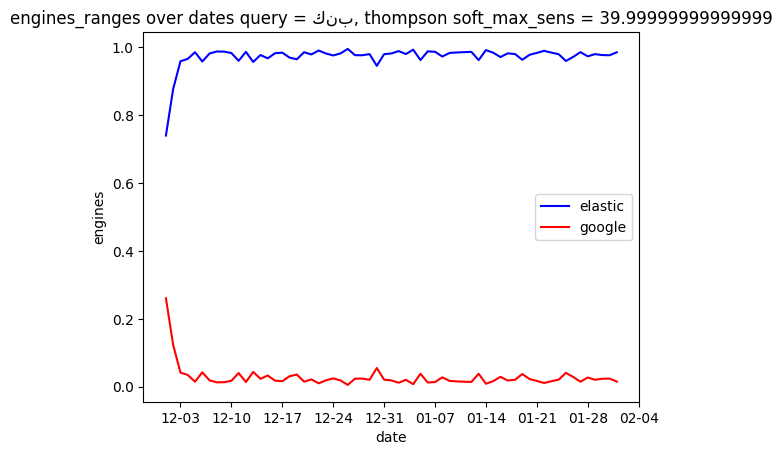

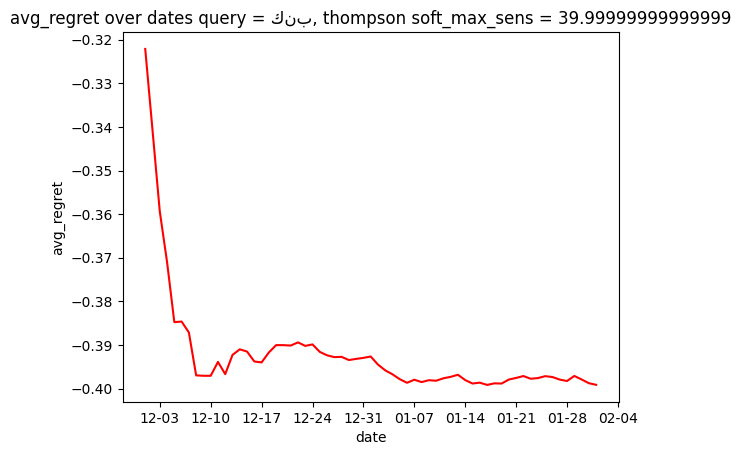

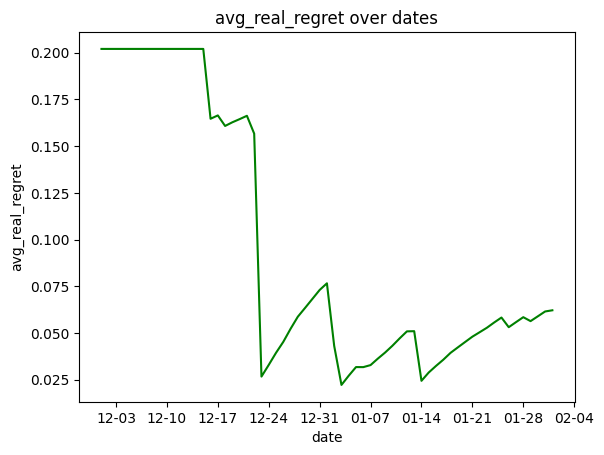

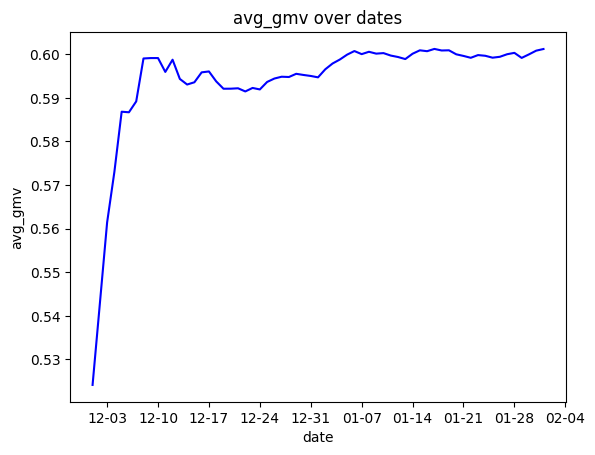

In [33]:
# Start Experiment

N = 50
total_avg_gmv_res = 0
total_regret_res = 0
total_real_avg_gmv_res = 0
total_real_regret_res = 0
mn_regret = 100000000000000
bst_conf = -1
bst_sens = -1
UCB_CONFIDENCE = 1000
SOFTMAX_SENSITIVITY = 100

queries_train = [
    ('شاحن ايفون', 'sa', '2024-12-01', '2025-02-01')
    # ('شاحن ايفون', 'sa', '2024-12-01', '2025-02-01'),
    # ('شاحن ايفون', 'sa', '2024-12-01', '2025-02-01'),
    # ('نايك', 'sa', '2024-12-01', '2025-02-01'),
    # ('vivo x200 pro mobile', 'sa', '2024-12-01', '2025-02-01'),
    # ('كنب', 'sa', '2024-12-01', '2025-02-01')
]

start = 0.128
end = 65.536
num_of_steps = 5
sensitivities = np.logspace(np.log10(start), np.log10(end), num=num_of_steps)

experiment_results = pd.DataFrame(columns=['query', 'country', 'date',  'engines_range', 'config', 'algo_regret', 'real_regret', 'algo_gmv', 'real_gmv'])
for query_it, country_it, start_date_it, end_date_it in queries_train:
    for sensitivity in sensitivities:
        res = run_algorithm(
                query_it, country_it, start_date_it, end_date_it, ThompsonScoringAlgorithm(sensitivity))

        if len(res.sofar_avg_gmvs) == 0:
            continue

        result_data = {}
        result_data['query'] = query_it
        result_data['country'] = country_it
        result_data['date'] = start_date_it
        result_data['engines_range'] = res.engines_ranges
        result_data['config'] = ThompsonScoringAlgorithm(sensitivity)
        result_data['algo_regret'] = res.total_avg_regrets
        result_data['real_regret'] = res.total_avg_real_regrets
        result_data['algo_gmv'] = res.sofar_avg_gmvs
        result_data['real_gmv'] = res.total_avg_real_gmvs

        experiment_results = pd.concat([experiment_results, pd.DataFrame(result_data)])
        # show_graph_multiple([[x.left for x in res.engines_ranges], [x.right for x in res.engines_ranges]], res.days, f'engines_ranges over dates query = {query_it}, thompson soft_max_sens = {sensitivity}', ['elastic', 'google'], ['b', 'r'])
        # show_graph(res.total_avg_regrets, res.days, f'avg_regret over dates query = {query_it}, thompson soft_max_sens = {sensitivity}', 'avg_regret', 'r')
        # show_graph(res.total_avg_real_regrets, res.days, f'avg_real_regret over dates query = {query_it}, thompson soft_max_sens = {sensitivity}', 'avg_real_regret', 'g')
        # show_graph(res.sofar_avg_gmvs, res.days, f'avg_gmv over dates query = {query_it}, thompson soft_max_sens = {sensitivity}', 'avg_gmv', 'b')

print(experiment_results)